# Here we develop the 3D FBP for cryo-ET data

## Basic workflow

1. I need to start with data preprocess

2. Convert the projection in log space

3. Start the FBP reconstrcution

file_list: ['D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\00.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\01.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\02.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\03.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\04.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\05.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\06.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\07.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\08.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM3D\\09.tif', 'D:\\datasets\\cryo\\Dataset\\Real_CovidInfectedCell\\Micrographs\\Denoised_BM

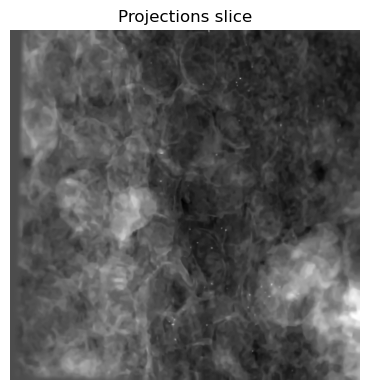

In [14]:
import os
import numpy as np
from PIL import Image
import re
import glob
import matplotlib.pyplot as plt

# data path
# for clean data
folder_path = r"D:\datasets\cryo\Dataset\Synthetic\Micrographs\Clean"
angle_file="tilt.rawtlt"

#for real data
folder_path= r"D:\datasets\cryo\Dataset\Real_CovidInfectedCell\Micrographs\Denoised_BM3D"
angle_file = '1_1_TomoSer2.rawtlt'

size=1024
def dataLoader(folder, resize_to=None):
    """
    Load cryo-ET projection data and convert it to log space using Beer-Lambert law.
    
    Parameters:
        folder (str): Path to folder containing .tif projection images.
        resize_to (tuple or None): (new_W, new_H), if not None, resize images.
    
    Returns:
        proj_log (np.ndarray): Log-transformed projections, shape (N, H, W).
    """
    file_list = sorted(glob.glob(f"{folder}/*.tif"))
    print(f"file_list: {file_list}")

    projections = []
    for f in file_list:
        img = Image.open(f).convert("F")  # "F" mode for float32
        
        if resize_to is not None:
            img = img.resize(resize_to, Image.BILINEAR)
        
        projections.append(np.array(img, dtype=np.float32))

    proj = np.stack(projections, axis=-1)  # (H, W, N)
    I0 = np.max(proj)
    proj_log = -np.log(proj / I0 + 1e-6)

    return proj_log

def load_tilt_angles(file_path):
    """
    Load tilt angles from a .rawtlt file.

    Parameters:
        file_path (str): Path to the tilt.rawtlt file.
    
    Returns:
        np.ndarray: Array of tilt angles.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Remove empty lines and convert to float
    angles = [float(line.strip()) for line in lines if line.strip()]
    return np.array(angles)


proj_log=dataLoader(folder_path, resize_to=(size, size))#proj_log；(1000, 1000, 94)
proj_log = np.transpose(proj_log, (2, 0, 1))  # shape 变成 (N, H, W)
print(f"proj_log:{proj_log.shape}")
# get degrees angles
angles=load_tilt_angles(os.path.join(folder_path,angle_file))
print(f"angles:{angles}")


plt.figure(figsize=(10, 4))
plt.title("Projections slice")
plt.imshow(proj_log[0], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

## Use FBP for reconstruction in cpu

run_time=50.752774200052954 s.
recon:(1024, 1024, 1024)


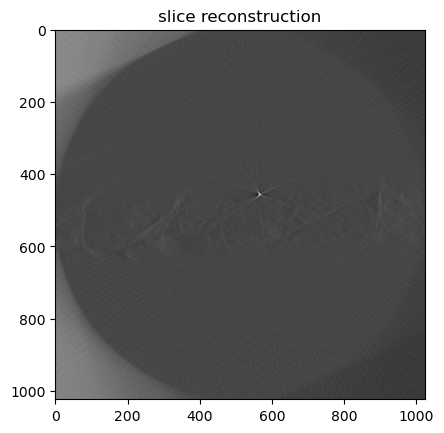

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.ndimage import map_coordinates
from skimage.transform import iradon
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import tomopy
import time
from numba import njit, prange

# Step 1: Ram-Lak filter
def apply_ramlak_filter(sino):
    n, n_angles = sino.shape
    f = fftfreq(n).reshape(-1, 1)
    filter_kernel = 2 * np.abs(f)
    sino_fft = fft(sino, axis=0)
    filtered_fft = sino_fft * filter_kernel
    return np.real(ifft(filtered_fft, axis=0))  # shape: (n, n_angles)
# Step 2: Back Projection (accelerated with numba)
@njit(parallel=True)
def backproject_2d_numba(filtered_sino, angles, output_size):
    recon = np.zeros((output_size, output_size), dtype=np.float32)
    n = filtered_sino.shape[0]
    x = np.arange(output_size) - output_size // 2
    y = np.arange(output_size) - output_size // 2
    for i in prange(output_size):
        for j in prange(output_size):
            xx = x[j]
            yy = y[i]
            sum_val = 0.0
            for k in range(len(angles)):
                angle = angles[k]
                t = xx * np.cos(angle) + yy * np.sin(angle)
                t = t * (n / output_size) + n // 2
                t = min(max(t, 0), n - 2)
                t0 = int(t)
                t1 = t0 + 1
                alpha = t - t0
                val = (1 - alpha) * filtered_sino[t0, k] + alpha * filtered_sino[t1, k]
                sum_val += val
            recon[i, j] = sum_val * (np.pi / len(angles))
    return recon

# Step 2: single layer Back Projection
def backproject_2d(filtered_sino, angles, output_size):
    recon = np.zeros((output_size, output_size), dtype=np.float32)
    n = filtered_sino.shape[0]
    x = np.arange(output_size) - output_size // 2
    y = np.arange(output_size) - output_size // 2
    xx, yy = np.meshgrid(x, y)
    
    for i, angle in enumerate(angles):
        t = xx * np.cos(angle) + yy * np.sin(angle)
        t = t * (n / output_size) + n // 2
        t = np.clip(t, 0, n - 1)
        projection = filtered_sino[:, i]
        recon += np.interp(t, np.arange(n), projection)
    
    recon *= np.pi / len(angles)
    return recon

# Step 3: main function：for each slice apply FBP
def fbp_reconstruct_manual(projs, angles):
    num_angles, num_slices, num_detectors = projs.shape
    recon_slices = []
    
    run_time=0.0
    for i in range(num_slices):
        sino = projs[:, i, :].T  # shape: (num_detectors, num_angles)
        filtered = apply_ramlak_filter(sino)
        # print(f"{i}-filtered:{filtered}")
        # print(f"filtered：{filtered.shape}")#filtered：(16, 94)
        start = time.perf_counter()
        recon = backproject_2d_numba(filtered, angles, output_size=num_detectors)
        end = time.perf_counter()
        time_iterval=end-start
        run_time+=time_iterval
        recon_slices.append(recon)
        # exit()
    print(f"run_time={run_time} s.")
    return np.stack(recon_slices, axis=0)  # shape: (num_slices, H, W)

#get rad angles
rad_angles=np.deg2rad(angles)
recon = fbp_reconstruct_manual(proj_log, rad_angles)

print(f"recon:{recon.shape}")#
recon.tofile(f"volume_output_{size}.bin")
import matplotlib.pyplot as plt
plt.imshow(recon[0], cmap='gray')
plt.title("slice reconstruction")
plt.show()

## Integer querry function ,I need a function which can return any densities in the space

In [ ]:
from numba import njit
import numpy as np

@njit
def query_fbp_point(filtered_sino, cosines, sines, n_det, out_sz, x, y):
    """
    filtered_sino: (n_det, n_angles)
    cosines, sines: (n_angles,)
    n_det: number of detectors
    out_sz: 输出网格在 x 和 y 方向上的大小（通常等于 n_det）
    x,y: 查询点坐标（以像素为单位，中心在 (0,0)）
    """
    n_angles = cosines.shape[0]
    acc = 0.0
    for k in range(n_angles):
        # 1) 计算 t = x·cosθ + y·sinθ
        t = x * cosines[k] + y * sines[k]
        # 2) 从像素坐标映射到探测器编号
        t = t * (n_det / out_sz) + n_det / 2
        # 3) 边界裁剪
        if t < 0:
            t = 0.0
        elif t > n_det - 2:
            t = n_det - 2.0
        # 4) 线性插值
        i0 = int(t)
        alpha = t - i0
        val = (1 - alpha) * filtered_sino[i0, k] + alpha * filtered_sino[i0+1, k]
        acc += val
    # 5) 乘上 π/|θ|
    return acc * (np.pi / n_angles)
from numba import prange

@njit(parallel=True)
def reconstruct_volume_by_query(filtered_vol, cosines, sines, n_det, out_sz, Nz, Ny, Nx):
    """
    filtered_vol: (Nz, n_det, n_angles)
    cosines, sines: (n_angles,)
    n_det: 探测器数量
    out_sz: 输出在 x,y 方向的像素数（通常 = n_det）
    Nz,Ny,Nx: 体积在 z,y,x 方向的像素数
    返回 vol: (Nz, Ny, Nx)
    """
    vol = np.zeros((Nz, Ny, Nx), dtype=np.float32)
    for z in prange(Nz):
        sino = filtered_vol[z]  # (n_det, n_angles)
        for i in range(Ny):
            # 将像素索引映射到以 0 为中心的坐标
            y = i - Ny//2
            for j in range(Nx):
                x = j - Nx//2
                vol[z, i, j] = query_fbp_point(sino, cosines, sines, n_det, out_sz, x, y)
    return vol

# 假设 projs.shape = (num_angles, num_slices, num_detectors)
num_angles, num_slices, num_detectors = proj_log.shape
# 1) 预计算角度的 cos/sin
cosines = np.cos(rad_angles)
sines   = np.sin(rad_angles)

# 2) 预过滤所有层
filtered_vol = np.zeros((num_slices, num_detectors, num_angles), dtype=np.float32)
for z in range(num_slices):
    sino = proj_log[:, z, :].T                  # (n_det, n_angles)
    filtered_vol[z] = apply_ramlak_filter(sino)

# 3) 按需查询整个网格（或单独某点）
Nz, Ny, Nx = num_slices, num_detectors, num_detectors
volume = reconstruct_volume_by_query(
    filtered_vol, cosines, sines,
    num_detectors, num_detectors,
    Nz, Ny, Nx
)
import matplotlib.pyplot as plt
plt.imshow(volume[0], cmap='gray')
plt.title("querry reconstruction")
plt.show()


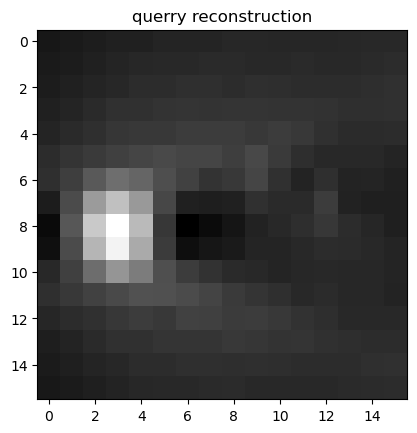

In [ ]:
from numba import njit, prange
import numpy as np

@njit
def query_fbp_point_2d(filtered_sino, cosines, sines, n_det, out_sz, x, y):
    """
    在单层 (2D) 上查询浮点 (x,y) 处的密度值。
    filtered_sino: (n_det, n_angles)
    cosines, sines: (n_angles,)
    n_det: 探测器数量
    out_sz: 输出网格在 x,y 方向的像素数（通常 = n_det）
    x,y: 以像素为单位、中心在 (0,0) 的浮点坐标
    """
    n_angles = cosines.shape[0]
    acc = 0.0
    for k in range(n_angles):
        # 1) 计算投影距离 t
        t = x * cosines[k] + y * sines[k]
        # 2) 映射到探测器编号
        t = t * (n_det / out_sz) + n_det * 0.5
        # 3) 边界裁剪
        if t < 0.0:
            t = 0.0
        elif t > n_det - 2:
            t = n_det - 2.0
        # 4) 线性插值
        i0 = int(t)
        alpha = t - i0
        val = (1.0 - alpha) * filtered_sino[i0, k] + alpha * filtered_sino[i0+1, k]
        acc += val
    # 5) 乘上 π/|θ|
    return acc * (np.pi / n_angles)

@njit
def query_fbp_point_3d(filtered_vol, cosines, sines, n_det, out_sz, x, y, z):
    """
    支持任意浮点 z 的 3D 查询。
    filtered_vol: (Nz, n_det, n_angles)
    cosines, sines: (n_angles,)
    n_det: 探测器数量
    out_sz: 输出网格在 x,y 方向的像素数
    x,y: 以像素为单位、中心在 (0,0) 的浮点坐标
    z: 切片索引的浮点坐标，范围 [0, Nz-1]
    """
    Nz = filtered_vol.shape[0]
    # 限制 z 在合法范围内
    if z < 0.0:
        z = 0.0
    elif z > Nz - 1:
        z = Nz - 1.0

    # 取出相邻整数层
    z0 = int(z)
    z1 = z0 + 1 if z0 < Nz - 1 else z0
    tz = z - z0

    # 分别查询两层
    val0 = query_fbp_point_2d(filtered_vol[z0], cosines, sines, n_det, out_sz, x, y)
    val1 = query_fbp_point_2d(filtered_vol[z1], cosines, sines, n_det, out_sz, x, y)
    # 在 z 方向上线性插值
    return (1.0 - tz) * val0 + tz * val1


# 假设 projs.shape = (num_angles, num_slices, num_detectors)
num_angles, num_slices, num_detectors = proj_log.shape
# 1) 预计算角度的 cos/sin
cosines = np.cos(rad_angles)
sines   = np.sin(rad_angles)

# 2) 预过滤所有层
filtered_vol = np.zeros((num_slices, num_detectors, num_angles), dtype=np.float32)
for z in range(num_slices):
    sino = proj_log[:, z, :].T                  # (n_det, n_angles)
    filtered_vol[z] = apply_ramlak_filter(sino)

num_angles, num_slices, num_detectors = proj_log.shape
Nz, Ny, Nx = num_slices, num_detectors, num_detectors
vol = np.zeros((Nz, Ny, Nx), dtype=np.float32)
for z in prange(Nz):
    sino = filtered_vol[z]  # (n_det, n_angles)
    for i in range(Ny):
        # 将像素索引映射到以 0 为中心的坐标
        y = i - Ny//2
        for j in range(Nx):
            x = j - Nx//2
            vol[z, i, j] = query_fbp_point_3d(
    filtered_vol, cosines, sines,
    n_det=num_detectors, out_sz=num_detectors,
    x=x, y=y, z=z
)
volume.tofile("volume_output.bin")
import matplotlib.pyplot as plt
plt.imshow(vol[0], cmap='gray')
plt.title("querry reconstruction")
plt.show()


In [15]:
# 保存文件
recon.tofile("reconstruction_volume.raw")

## Volume render

In [ ]:
import numpy as np
import pygame
from numba import njit, prange

# ==== Volume generation ====
def generate_volume(size=64):
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    z = np.linspace(-10, 10, size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    return np.exp(-((3*X**2 + 5*Y**2 + Z**2)))

# ==== View matrix from yaw/pitch ====
def get_view_matrix(yaw, pitch):
    cos_y, sin_y = np.cos(yaw), np.sin(yaw)
    cos_p, sin_p = np.cos(pitch), np.sin(pitch)
    R_y = np.array([[cos_y, 0, sin_y],
                    [0,     1, 0],
                    [-sin_y, 0, cos_y]])
    R_x = np.array([[1, 0, 0],
                    [0, cos_p, -sin_p],
                    [0, sin_p, cos_p]])
    return R_x @ R_y

# ==== Ray marching rendering (Numba accelerated) ====
@njit(parallel=True)
def render_volume(volume, view_matrix, zoom_factor, image_size=256, step_size=0.01):
    D, H, W = volume.shape
    img = np.zeros((image_size, image_size))

    for i in prange(image_size):
        for j in prange(image_size):
            ray_dir = np.dot(view_matrix, np.array([
                2 * (j / (image_size - 1)) - 1.0,
                2 * (i / (image_size - 1)) - 1.0,
                1.0
            ]))
            ray_dir /= np.linalg.norm(ray_dir)
            cam_origin = -zoom_factor * view_matrix[:, 2]

            color = 0.0
            opacity = 0.0
            t = 0.0
            while t < 4.0 and opacity < 0.95:
                pos = cam_origin + t * ray_dir
                pos_norm = (pos + 1.0) / 2.0
                x = pos_norm[0] * (D - 1)
                y = pos_norm[1] * (H - 1)
                z = pos_norm[2] * (W - 1)
                if 0 <= x < D-1 and 0 <= y < H-1 and 0 <= z < W-1:
                    xi, yi, zi = int(x), int(y), int(z)
                    density = volume[xi, yi, zi]
                    alpha = 1.0 - np.exp(-density * step_size)
                    color += (1.0 - opacity) * alpha * density
                    opacity += (1.0 - opacity) * alpha
                t += step_size
            img[i, j] = color
    return img

# ==== Pygame 交互窗口 ====
def run_renderer():
    pygame.init()
    size = 256
    screen = pygame.display.set_mode((size, size))
    clock = pygame.time.Clock()

    volume = recon#generate_volume(128)
    yaw, pitch = 0.0, 0.0
    zoom_factor = 3.0
    dragging = False
    last_mouse = None

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return
            elif event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                return
            elif event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    dragging = True
                    last_mouse = pygame.mouse.get_pos()
            elif event.type == pygame.MOUSEBUTTONUP:
                dragging = False
            elif event.type == pygame.MOUSEMOTION and dragging:
                x, y = pygame.mouse.get_pos()
                dx = (x - last_mouse[0]) * 0.01
                dy = (y - last_mouse[1]) * 0.01
                yaw += dx
                pitch += dy
                last_mouse = (x, y)
            elif event.type == pygame.MOUSEWHEEL:
                zoom_factor *= 0.9 if event.y > 0 else 1.1
                zoom_factor = np.clip(zoom_factor, 0.5, 10.0)

        view_matrix = get_view_matrix(yaw, pitch)
        img = render_volume(volume, view_matrix, zoom_factor, image_size=size)

        # 转换为 RGB 显示
        norm = np.clip(img / np.max(img), 0, 1)
        surface = pygame.surfarray.make_surface((norm.T * 255).astype(np.uint8).repeat(3).reshape(size, size, 3))
        screen.blit(surface, (0, 0))

        # ==== 添加一个小坐标系指示器 ====
        axis_origin = np.array([40, size - 40])  # 屏幕左下角
        axis_len = 30  # 像素长度

        for vec, color in zip([np.array([1, 0, 0]),  # X Red
                               np.array([0, 1, 0]),  # Y Green
                               np.array([0, 0, 1])], # Z Blue
                              [(255, 0, 0), (0, 255, 0), (0, 0, 255)]):
            v_rot = view_matrix @ vec
            end = axis_origin + axis_len * v_rot[:2][::-1]  # 注意 y 向下
            pygame.draw.line(screen, color, axis_origin, end.astype(int), 2)

        pygame.display.flip()
        clock.tick(30)

run_renderer()


pygame 2.6.1 (SDL 2.28.4, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


: 